## 160k Spotify songs from 1921 to 2020 - analysis and prediction of popularity

The following dataset contains 19 columns, which represent the attributes:

- `id`: a simple identifier for each individual Spotify song, unique for each song
- `name`: the name of the song
- `artists`: the names of the artists who contributed to the song
- `duration_ms`: the duration of the song in milliseconds
- `release_date`: the release date of the song in MM/DD/YYYY format if month and day are available, otherwise YYYY
- `year`: the release year of the song in YYYY format
- `acousticness`: describes how acoustic a song is on a scale from 0.0 to 1.0; a value of 1.0 means the song is acoustic.
- `danceability`: describes how suitable a track is for dancing on a scale from 0.0 to 1.0; based on a combination of musical elements
- `energy`: represents a perceptual measure of intensity and activity of a song on a scale from 0.0 to 1.0 (typically, tracks with high energy sound fast, loud, and noisy)
- `instrumentalness`: represents the amount of vocals in the song; the closer it is to 1.0, the more instrumental the song is
- `liveness`: describes the probability that the song was recorded with a live audience
- `loudness`: indicates the average volume of a song in decibels; in this dataset, the range of values is [-60, 3.85]
- `speechiness`: represents the presence of spoken words in a song; the closer it is to 1.0, the more spoken the song is
- `tempo`: the average beats per minute of a song
- `valence`: a measure from 0.0 to 1.0 describing the musical positiveness given by a track; tracks with high valence sound more positive (happy, cheerful, euphoric), while tracks with low valence sound more negative (sad, angry)
- `mode`: indicates the modality content of a track; 1 = major key, 0 = minor key
- `key`: indicates the estimated key of a track
- `popularity`: represents the popularity of a track with a value in the range [0, 100], where 100 indicates a highly popular song
- `explicit`: a boolean indicating whether the track has explicit lyrics; 1 = True, 0 = False

### Our goal

With this notebook, we want to understand if there is any correlation between the various attributes of a song and its popularity; we will subsequently try to find a predictive method capable of reasonably predicting how popular a song can become based on its musical features.

First, let's import the libraries we will need

In [1]:
# for data analysis 
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import ttest_ind
from collections import Counter

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns 

# machine learning
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

Let's import the dataset and display it

In [2]:
songs = pd.read_csv("data.csv")
songs.head()

,id,name,artists,duration_ms,release_date,year,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,mode,key,popularity,explicit
0,0gNNToCW3qjabgTyBSjt3H,!Que Vida! - Mono Version,['Love'],220560,11/1/66,1966,0.5250,0.600,0.540,0.00305,0.100,-11.803,0.0328,125.898,0.547,1,9,26,0
1,0tMgFpOrXZR6irEOLNWwJL,"""40""",['U2'],157840,2/28/83,1983,0.2280,0.368,0.480,0.70700,0.159,-11.605,0.0306,150.166,0.338,1,8,21,0
2,2ZywW3VyVx6rrlrX75n3JB,"""40"" - Live",['U2'],226200,8/20/83,1983,0.0998,0.272,0.684,0.01450,0.946,-9.728,0.0505,143.079,0.279,1,8,41,0
3,6DdWA7D1o5TU2kXWyCLcch,"""40"" - Remastered 2008",['U2'],157667,2/28/83,1983,0.1850,0.371,0.545,0.58200,0.183,-9.315,0.0307,150.316,0.310,1,8,37,0
4,3vMmwsAiLDCfyc1jl76lQE,"""40"" - Remastered 2008",['U2'],157667,2/28/83,1983,0.1850,0.371,0.545,0.58200,0.183,-9.315,0.0307,150.316,0.310,1,8,35,0


Let's display some information related to the dataset

In [3]:
songs.info()
songs.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169907 entries, 0 to 169906
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                169907 non-null  object 
 1   name              169907 non-null  object 
 2   artists           169907 non-null  object 
 3   duration_ms       169907 non-null  int64  
 4   release_date      169907 non-null  object 
 5   year              169907 non-null  int64  
 6   acousticness      169907 non-null  float64
 7   danceability      169907 non-null  float64
 8   energy            169907 non-null  float64
 9   instrumentalness  169907 non-null  float64
 10  liveness          169907 non-null  float64
 11  loudness          169907 non-null  float64
 12  speechiness       169907 non-null  float64
 13  tempo             169907 non-null  float64
 14  valence           169907 non-null  float64
 15  mode              169907 non-null  int64  
 16  key               16

(169907, 19)

In [4]:
songs.isnull().sum()

id                  0
name                0
artists             0
duration_ms         0
release_date        0
year                0
acousticness        0
danceability        0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
mode                0
key                 0
popularity          0
explicit            0
dtype: int64

### Data Cleaning

Fortunately, there are no null values to handle in any column.

There are some columns that are not very relevant for our analysis, such as `id` and `release_date` (not very useful since many songs only contain the release year, which is already captured in the `year` column): I will remove them to simplify the dataset

In [5]:
songs.drop(["id", "release_date"], axis=1, inplace=True)
songs.head(20)

,name,artists,duration_ms,year,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,mode,key,popularity,explicit
0,!Que Vida! - Mono Version,['Love'],220560,1966,0.525000,0.600,0.5400,0.003050,0.1000,-11.803,0.0328,125.898,0.5470,1,9,26,0
1,"""40""",['U2'],157840,1983,0.228000,0.368,0.4800,0.707000,0.1590,-11.605,0.0306,150.166,0.3380,1,8,21,0
2,"""40"" - Live",['U2'],226200,1983,0.099800,0.272,0.6840,0.014500,0.9460,-9.728,0.0505,143.079,0.2790,1,8,41,0
3,"""40"" - Remastered 2008",['U2'],157667,1983,0.185000,0.371,0.5450,0.582000,0.1830,-9.315,0.0307,150.316,0.3100,1,8,37,0
4,"""40"" - Remastered 2008",['U2'],157667,1983,0.185000,0.371,0.5450,0.582000,0.1830,-9.315,0.0307,150.316,0.3100,1,8,35,0
5,"""45""",['The Gaslight Anthem'],202493,2012,0.000696,0.315,0.9700,0.000000,0.2770,-4.709,0.1020,178.068,0.4230,1,8,48,0
6,"""8"" Teen",['? & The Mysterians'],166693,1966,0.111000,0.657,0.8720,0.713000,0.0857,-7.279,0.0512,136.512,0.7380,1,2,17,0
7,"""A"" You're Adorable",['Brian Hyland'],151680,1961,0.482000,0.615,0.3750,0.000000,0.1110,-10.362,0.0319,110.720,0.9220,0,0,44,0
8,"""Addio, mio dolce amor!"" from Edgar (Act III) ...","['Giacomo Puccini', 'Renata Scotto', 'Eve Quel...",235933,1946,0.980000,0.160,0.1700,0.000980,0.1100,-18.059,0.0460,168.449,0.0389,1,10,0,0
9,"""Amarilli mia bella"" - 1955 Version","['Giulio Caccini', 'Irma Kolassi', 'Jacqueline...",236547,1952,0.995000,0.138,0.0371,0.001530,0.0584,-24.593,0.0572,77.214,0.0706,1,7,0,0


We can see that the artists' names have apostrophes and brackets around them: to simplify the reading, let's remove these symbols

In [6]:
songs['artists'] = songs['artists'].str.replace("[","")
songs['artists'] = songs['artists'].str.replace("'","")
songs['artists'] = songs['artists'].str.replace("]","")
songs.head()

,name,artists,duration_ms,year,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,mode,key,popularity,explicit
0,!Que Vida! - Mono Version,Love,220560,1966,0.5250,0.600,0.540,0.00305,0.100,-11.803,0.0328,125.898,0.547,1,9,26,0
1,"""40""",U2,157840,1983,0.2280,0.368,0.480,0.70700,0.159,-11.605,0.0306,150.166,0.338,1,8,21,0
2,"""40"" - Live",U2,226200,1983,0.0998,0.272,0.684,0.01450,0.946,-9.728,0.0505,143.079,0.279,1,8,41,0
3,"""40"" - Remastered 2008",U2,157667,1983,0.1850,0.371,0.545,0.58200,0.183,-9.315,0.0307,150.316,0.310,1,8,37,0
4,"""40"" - Remastered 2008",U2,157667,1983,0.1850,0.371,0.545,0.58200,0.183,-9.315,0.0307,150.316,0.310,1,8,35,0


Now let's check that there are no anomalies with the columns that must have values within a certain range, by checking what values are there

In [7]:
print(songs["mode"].unique()) # should stay between 0 and 1
print(songs["key"].unique()) # should stay between 0 and 11
print(songs["explicit"].unique()) # should stay between 0 and 1

[1 0]
[ 9  8  2  0 10  7  1 11  5  4  3  6]
[0 1]


In [8]:
print(str(songs["year"].min()) + " - " + str(songs["year"].max())) # range: [1921 – 2020]
print(str(songs["acousticness"].min()) + " - " + str(songs["acousticness"].max())) # range: [0.0 – 1.0]
print(str(songs["danceability"].min()) + " - " + str(songs["danceability"].max())) # range: [0.0 – 1.0]
print(str(songs["energy"].min()) + " - " + str(songs["energy"].max())) # range: [0.0 – 1.0]
print(str(songs["instrumentalness"].min()) + " - " + str(songs["instrumentalness"].max())) # range: [0.0 – 1.0]
print(str(songs["speechiness"].min()) + " - " + str(songs["speechiness"].max())) # range: [0.0 – 1.0]
print(str(songs["valence"].min()) + " - " + str(songs["valence"].max())) # range: [0.0 – 1.0]
print(str(songs["popularity"].min()) + " - " + str(songs["popularity"].max())) # range: [0 – 100]

1921 - 2020
0.0 - 0.996
0.0 - 0.988
0.0 - 1.0
0.0 - 1.0
0.0 - 0.969
0.0 - 1.0
0 - 100


Now let's check if there are any duplicate values

In [9]:
songs[songs.duplicated()]

,name,artists,duration_ms,year,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,mode,key,popularity,explicit
1134,"18 German Dances and Ecossaises, D. 783: No. 6...","Franz Schubert, William Kapell",35093,1945,0.9660,0.270,0.41100,0.87100,0.1440,-12.265,0.0949,189.704,0.3150,1,10,0,0
1136,"18 German Dances and Ecossaises, D. 783: No. 7...","Franz Schubert, William Kapell",44707,1945,0.9950,0.404,0.12200,0.45900,0.0896,-19.706,0.0514,137.046,0.4710,1,10,0,0
1142,"18 Wiener Damen Ländler und Ecossaisen, D. 734...","Franz Schubert, William Kapell",59373,1945,0.9880,0.666,0.29700,0.67900,0.1400,-15.679,0.1900,81.359,0.2860,1,7,0,0
1677,"3 Romanzen, Op. 28: 2. Einfach","Robert Schumann, William Kapell",208640,1945,0.9920,0.286,0.02310,0.91900,0.2130,-25.210,0.0329,75.078,0.0931,1,6,0,0
1762,"36 Original Dances, D. 365: No. 26, Deutscher ...","Franz Schubert, William Kapell",37867,1945,0.9810,0.697,0.18700,0.94600,0.3010,-17.202,0.0772,92.180,0.4200,1,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161255,Work / Final Rent Notice,Charlie Chaplin,538086,1931,0.6900,0.410,0.20200,0.75100,0.1570,-11.023,0.0543,99.483,0.2390,1,6,0,0
163246,You Don't Know Me - Radio Edit,"Jax Jones, RAYE",255307,2020,0.0701,0.881,0.69700,0.00001,0.2740,-8.374,0.1320,124.037,0.7260,0,11,1,1
165949,"Étude in C-Sharp Minor, Op. 10, No. 4","Frédéric Chopin, Vladimir Horowitz",127307,1928,0.9880,0.221,0.30400,0.90100,0.1120,-18.909,0.0320,169.587,0.4430,0,1,0,0
165955,"Étude in C-Sharp Minor, Op. 25, No. 7","Frédéric Chopin, Vladimir Horowitz",328267,1928,0.9920,0.244,0.00793,0.93400,0.0878,-32.492,0.0340,93.048,0.0691,0,1,0,0


There are 607 tuples that are duplicates; let's remove them to prevent them from altering our analysis.

In [10]:
songs.drop_duplicates(inplace=True)
songs.head()

,name,artists,duration_ms,year,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,mode,key,popularity,explicit
0,!Que Vida! - Mono Version,Love,220560,1966,0.5250,0.600,0.540,0.00305,0.100,-11.803,0.0328,125.898,0.547,1,9,26,0
1,"""40""",U2,157840,1983,0.2280,0.368,0.480,0.70700,0.159,-11.605,0.0306,150.166,0.338,1,8,21,0
2,"""40"" - Live",U2,226200,1983,0.0998,0.272,0.684,0.01450,0.946,-9.728,0.0505,143.079,0.279,1,8,41,0
3,"""40"" - Remastered 2008",U2,157667,1983,0.1850,0.371,0.545,0.58200,0.183,-9.315,0.0307,150.316,0.310,1,8,37,0
4,"""40"" - Remastered 2008",U2,157667,1983,0.1850,0.371,0.545,0.58200,0.183,-9.315,0.0307,150.316,0.310,1,8,35,0


### Visualization and statistical tests

We have finished cleaning the dataset and can now start manipulating it to extract some information.
Let's use a heatmap to check for correlations between columns; for our objectives, we will focus specifically on the `popularity` column

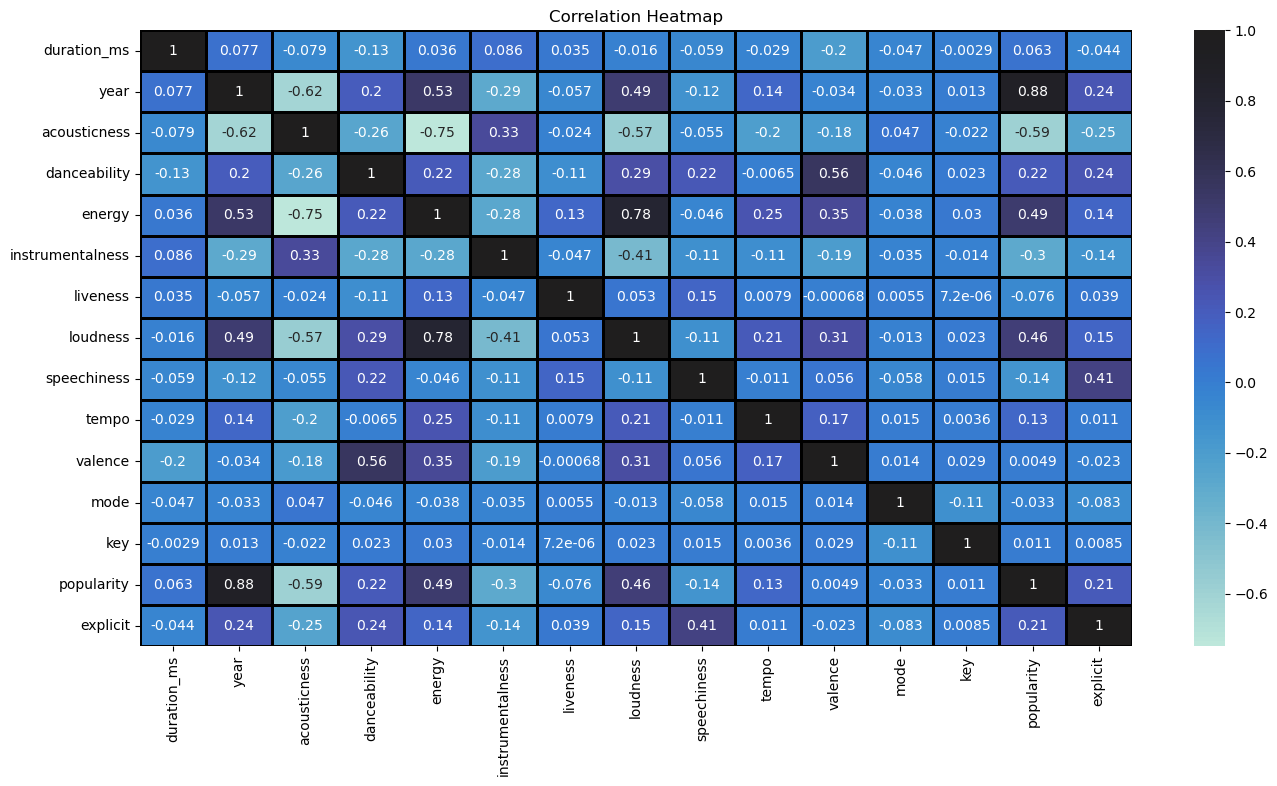

In [11]:
songs_2 = songs.select_dtypes(include=[np.number])
plt.figure(figsize=(16,8))
plt.title('Correlation Heatmap')
ax=sns.heatmap(songs_2.corr(),
               linewidth=2,
               annot=True,
               linecolor='black',
               center=1)

Observing the results of the correlation table, we can make the following observations about the attributes that contribute to a song's popularity (referring to the `popularity` column):

- The release year (`year` column) is highly correlated with popularity, but this is not really surprising: the Spotify algorithm considers the recency of a song's plays and the total number of listens it has received when determining its popularity;

- `energy` and `loudness` also show a positive correlation with popularity. This suggests that many popular songs are energetic, but it does not really mean they are highly danceable. However, it is important to note that high energy does not guarantee popularity, and low energy does not imply lack of popularity (_correlation is not causation!_);

- `acousticness` and `instrumentalness` exhibit an inverse correlation with popularity: this aligns with the trend of popular modern songs having more electronic sounds, as opposed to purely acoustic or orchestral compositions, which are mainly part of the songs of the last century;

Other attributes do not show significant relationships with song popularity.

Additionally, we can observe the following correlations among the attributes:
- `loudness` and `energy` are strongly positively correlated.
- `acousticness` is inversely correlated with `energy`, `year`, and `loudness`.

Based on these observations, we can predict that songs with high energy levels and electronic sounds have a higher probability of achieving popularity.

##### Musical features over the years

Let's visualize the trends of some musical features over time to see how music has changed over the years

Text(0.5, 0, 'Year')

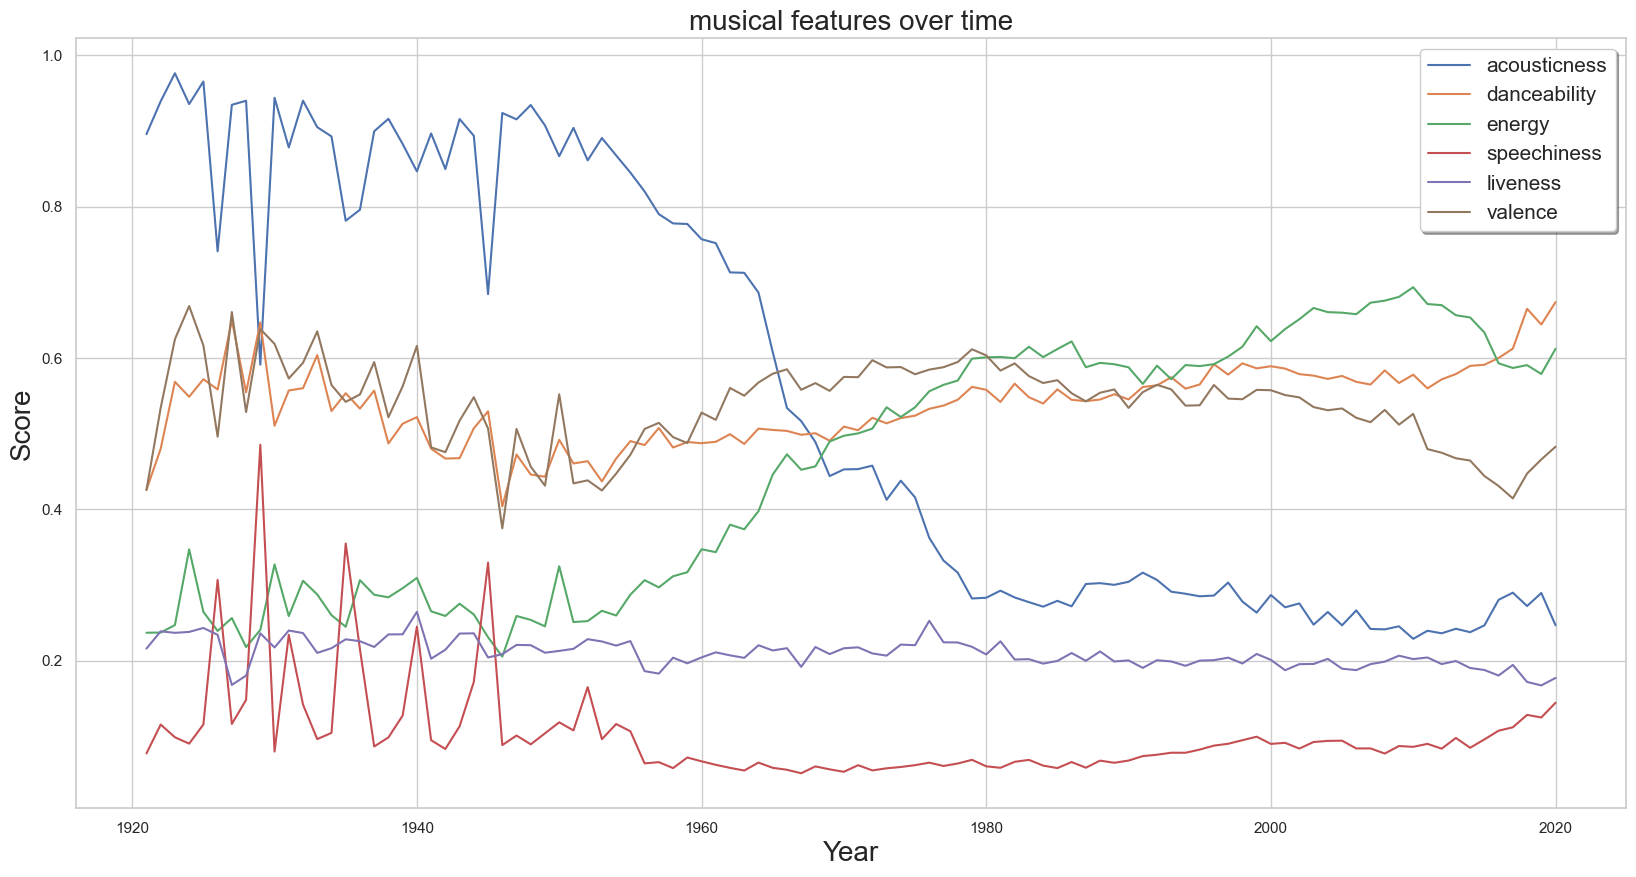

In [12]:
plt.figure(figsize=(20, 10))
sns.set(style="whitegrid")

target_cols = ["acousticness","danceability","energy","speechiness","liveness","valence"]
for c in target_cols:
    x = songs.groupby("year")[c].mean()
    ax= sns.lineplot(x=x.index,y=x,label=c)

ax.set_title('musical features over time', fontsize = 20)
ax.legend(fancybox=True, framealpha=1, shadow=True, prop={'size': 15}, loc = 'upper right')
ax.set_ylabel('Score', fontsize = 20)
ax.set_xlabel('Year', fontsize = 20)

As we can see from the plot, before 1960 songs generally had a high level of `acousticness`. After 1960, music started to become more energetic, and as the `energy` level increased, the level of acousticness dropped drastically, probably due to the development of music genres such as hip-hop and electronic music.

It is also interesting to note that `danceability` does not increase with increasing energy: this means that people find both energetic and acoustic music equally "easy" to dance to. Furthermore, the average `danceability` has remained fairly constant over the years: this further suggests that this attribute is probably not correlated with `acousticness` or `energy`, as these two attributes have significantly increased/decreased over the years.

Now let's display the 10 most popular songs in our dataset

Text(0.5, 0, 'Song Name')

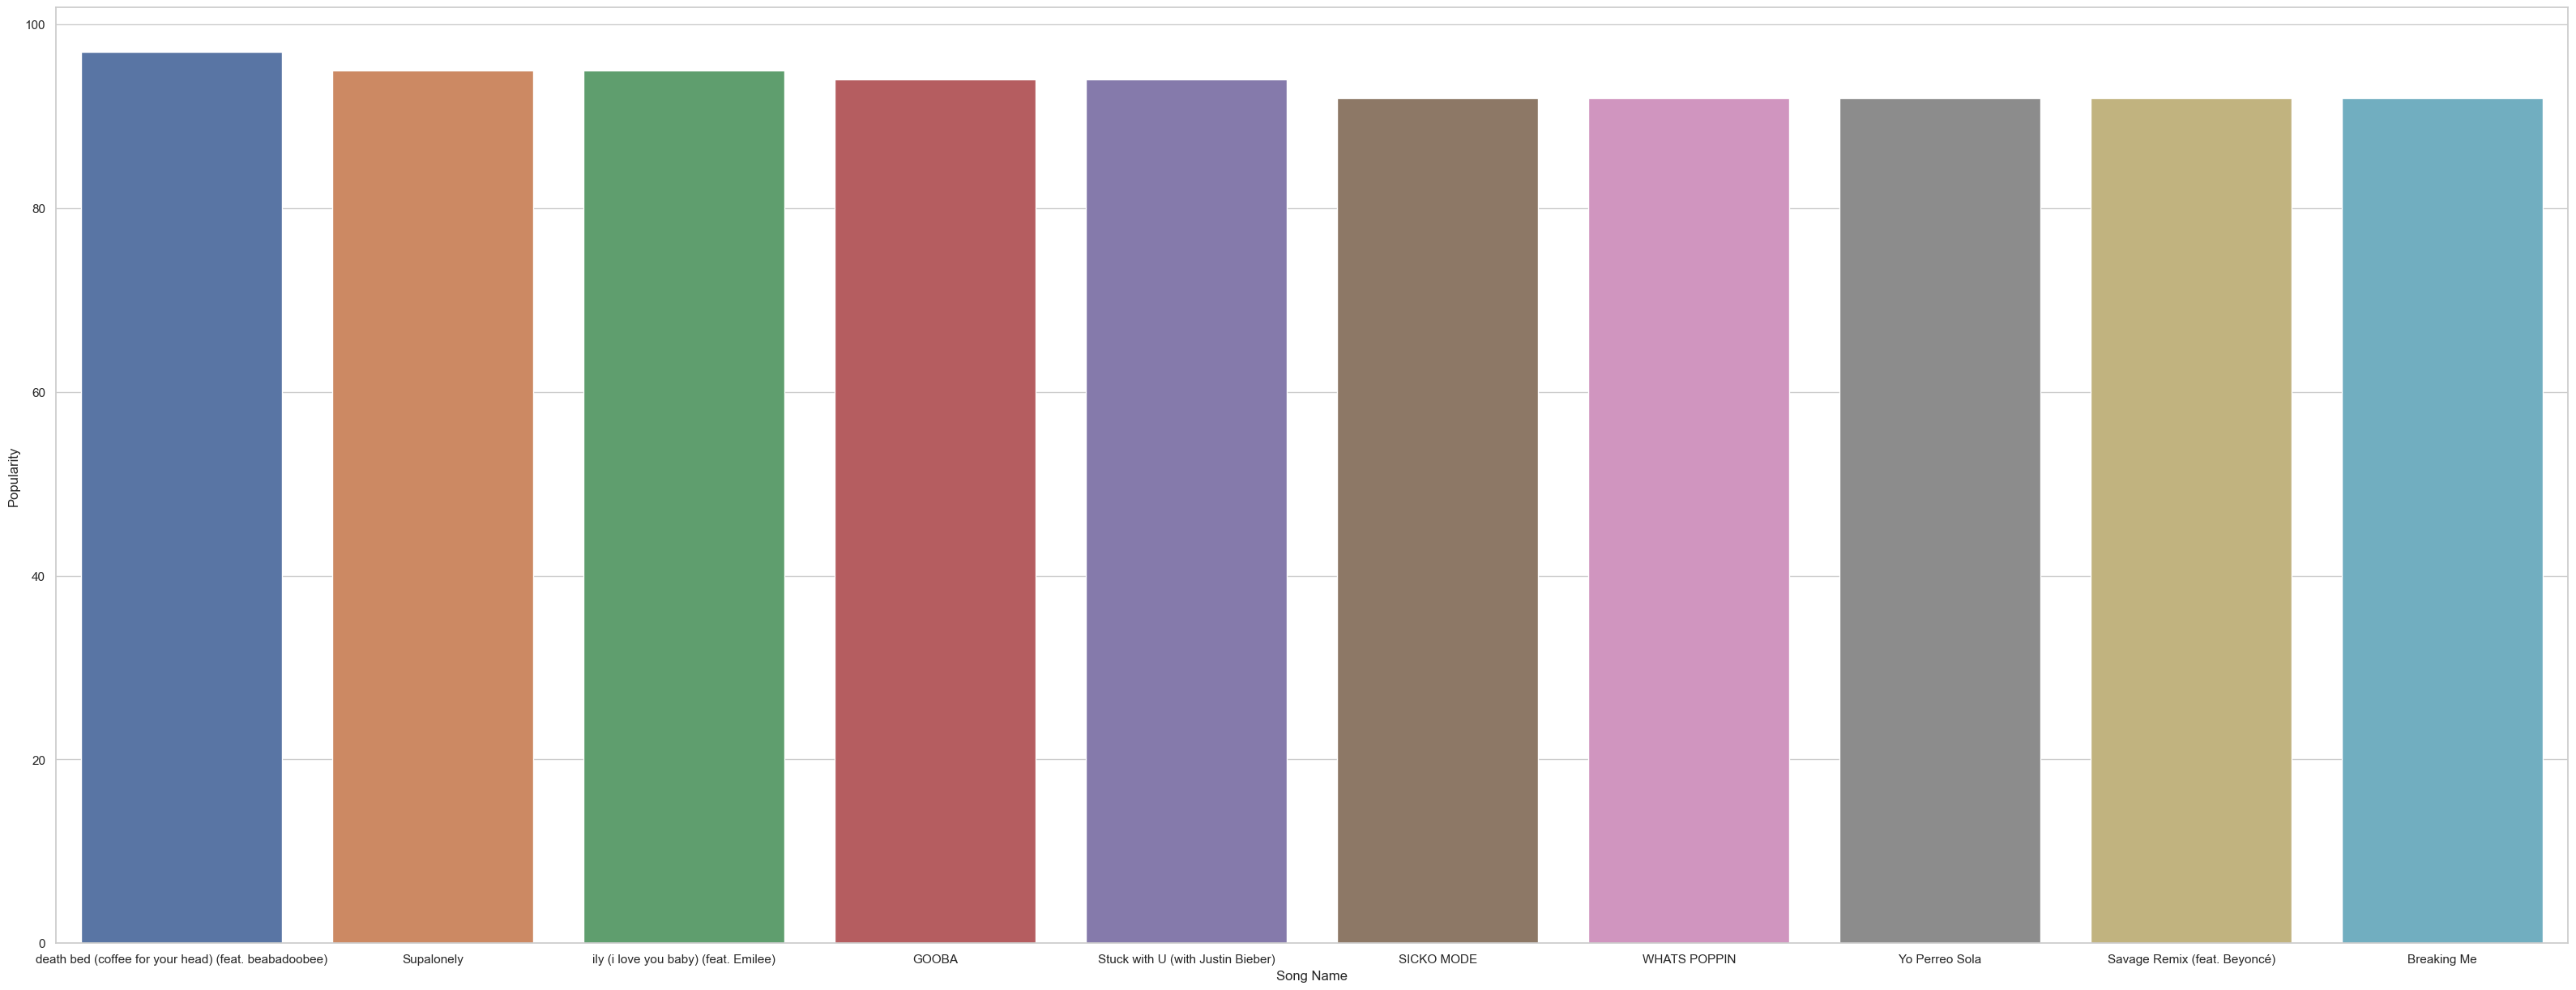

In [13]:
plt.figure(figsize=(40, 15))

x = songs.groupby("name")["popularity"].mean().sort_values(ascending=False).head(10)
axis = sns.barplot(x=x.index, y=x)

axis.set_ylabel('Popularity')
axis.set_xlabel('Song Name')

We can observe that indeed all the most popular songs belong to the EDM or hip-hop genres (genres with high energy values), and they are quite recent (the oldest song among these dates back only to 2018).

To further investigate our analysis, we prepare our dataset for OLAP analysis by quantizing the values of `popularity` into:

1. NOT POPULAR = [0, 24];
2. QUITE POPULAR = [25, 49];
3. POPULAR = [50, 74];
4. VERY POPULAR = [75, 100]

of `energy` into:

1. LOW ENERGY = [0.0, 0.24];
2. QUITE ENERGY = [0.25, 0.49];
3. ENERGETIC = [0.50, 0.74];
4. VERY ENERGETIC = [0.75, 1.0]

and of `acousticness` into:

1. LOW ACOUSTIC = [0.0, 0.24];
2. QUITE ACOUSTIC = [0.25, 0.49];
3. ACOUSTIC = [0.50, 0.74];
4. VERY ACOUSTIC = [0.75, 1.0]

and we add three new columns to the dataset with these values.

In [14]:
minimum = [0, 25, 50, 75]
maximum = [24, 49, 74, 100]
quantize_popularity = ['NOT POPULAR','QUITE POPULAR','POPULAR','VERY POPULAR']
for i in range(0,4):
    songs.loc[songs['popularity'].between(minimum[i], maximum[i], 'both'), 'quantize_popularity'] = quantize_popularity[i]
['quantize_popularity']


minimum = [0.0, 0.25, 0.50, 0.75]
maximum = [0.24, 0.49, 0.74, 1.00]
quantize_energy = ['LOW ENERGY','QUITE ENERGY','ENERGETIC','VERY ENERGETIC']
for i in range(0,4):
    songs.loc[songs['energy'].between(minimum[i], maximum[i], 'both'), 'quantize_energy'] = quantize_energy[i]
['quantize_energy']

minimum = [0.0, 0.25, 0.50, 0.75]
maximum = [0.24, 0.49, 0.74, 1.00]
quantize_acousticness = ['LOW ACOUSTIC','QUITE ACOUSTIC','ACOUSTIC','VERY ACOUSTIC']
for i in range(0,4):
    songs.loc[songs['acousticness'].between(minimum[i], maximum[i], 'both'), 'quantize_acousticness'] = quantize_acousticness[i]
['quantize_acousticness']

songs.head()

,name,artists,duration_ms,year,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,mode,key,popularity,explicit,quantize_popularity,quantize_energy,quantize_acousticness
0,!Que Vida! - Mono Version,Love,220560,1966,0.5250,0.600,0.540,0.00305,0.100,-11.803,0.0328,125.898,0.547,1,9,26,0,QUITE POPULAR,ENERGETIC,ACOUSTIC
1,"""40""",U2,157840,1983,0.2280,0.368,0.480,0.70700,0.159,-11.605,0.0306,150.166,0.338,1,8,21,0,NOT POPULAR,QUITE ENERGY,LOW ACOUSTIC
2,"""40"" - Live",U2,226200,1983,0.0998,0.272,0.684,0.01450,0.946,-9.728,0.0505,143.079,0.279,1,8,41,0,QUITE POPULAR,ENERGETIC,LOW ACOUSTIC
3,"""40"" - Remastered 2008",U2,157667,1983,0.1850,0.371,0.545,0.58200,0.183,-9.315,0.0307,150.316,0.310,1,8,37,0,QUITE POPULAR,ENERGETIC,LOW ACOUSTIC
4,"""40"" - Remastered 2008",U2,157667,1983,0.1850,0.371,0.545,0.58200,0.183,-9.315,0.0307,150.316,0.310,1,8,35,0,QUITE POPULAR,ENERGETIC,LOW ACOUSTIC


Now let's create the OLAP three-dimensional matrix, where the dimensions represent:

- The 4 matrices represent the 4 possible values of `popularity` (from top to bottom, we have the values from "NOT POPULAR" to "VERY POPULAR")
- The 4 rows in each matrix represent the 4 possible values of `energy` (from top to bottom, we have the values from "LOW ENERGY" to "VERY ENERGETIC")
- The 4 columns in each matrix represent the 4 possible values of `acousticness` (from left to right, we have the values from "LOW ACOUSTIC" to "VERY ACOUSTIC")

In [15]:
OLAP = np.zeros((len(quantize_popularity), len(quantize_energy), len(quantize_acousticness)), dtype=int)
for i in range(0, len(quantize_popularity)):
    for j in range(0, len(quantize_energy)):
        for k in range(0, len(quantize_acousticness)):
            OLAP[i, j, k] = int(((songs['quantize_popularity'] == quantize_popularity[i]) & 
                             (songs['quantize_energy'] == quantize_energy[j]) & 
                             (songs['quantize_acousticness'] == quantize_acousticness[k])).sum())

print(OLAP)

[[[  875   726  1366 23227]
  [ 1306  1502  3247 15448]
  [ 1651  1180  1872  3275]
  [ 1510   446   469   464]]

 [[  226   384  1123  6770]
  [ 3951  3691  4850  4673]
  [12183  4745  3063  1030]
  [16487  2086   912   224]]

 [[   96    97   277  1988]
  [ 1926  1561  1977  1539]
  [ 8760  2915  1515   319]
  [10444  1101   361    45]]

 [[    2     1     7    38]
  [  112    71    80    47]
  [  590   173    69    10]
  [  429    67    11     3]]]


The numerical values of each matrix indicate the number of songs that match the combination of the three components (for example, OLAP[0, 0, 0] (875) represents the number of songs that belong to the group ["NOT POPULAR", "LOW ENERGY", "LOW ACOUSTIC"])

Now let's have a **slicing** based on popularity values and let's display the matrix of very popular and popular songs

very popular songs:
[[  2   1   7  38]
 [112  71  80  47]
 [590 173  69  10]
 [429  67  11   3]]

popular songs:
[[   96    97   277  1988]
 [ 1926  1561  1977  1539]
 [ 8760  2915  1515   319]
 [10444  1101   361    45]]


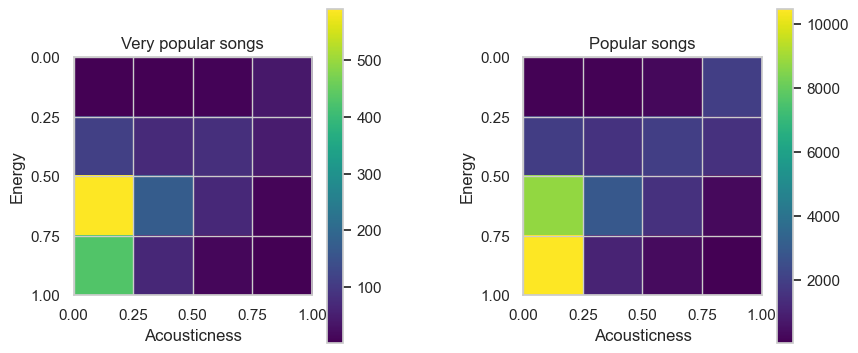

In [16]:
poco_popolare = OLAP[0, :, :]
abbastanza_popolare = OLAP[1, :, :]
popolare = OLAP[2, :, :]
molto_popolare = OLAP[3, :, :]

print('very popular songs:')
print(molto_popolare)
print('')
print('popular songs:')
print(popolare)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(molto_popolare, cmap='viridis', extent=[0, 1, 1, 0])
plt.colorbar()
plt.xticks([0.0, 0.25, 0.50, 0.75, 1.00])
plt.yticks([1.00, 0.75, 0.50, 0.25, 0.0])
plt.xlabel('Acousticness')
plt.ylabel('Energy')
plt.title('Very popular songs')

plt.subplot(1, 2, 2)
plt.imshow(popolare, cmap='viridis', extent=[0, 1, 1, 0])
plt.colorbar()
plt.xticks([0.0, 0.25, 0.50, 0.75, 1.00])
plt.yticks([1.00, 0.75, 0.50, 0.25, 0.0])
plt.xlabel('Acousticness')
plt.ylabel('Energy')
plt.title('Popular songs')

plt.tight_layout(pad=5.0) 
plt.show()


We can see that a large part of the popular and very popular songs in the dataset fall into the category of energetic and very energetic songs, and are not (very) acoustic.

At this point, we can perform a **dicing** to visualize how many songs are "NOT POPULAR", "QUITE POPULAR", "POPULAR", and "VERY POPULAR" with the following combinations of values:
1. "VERY ENERGETIC" and "LOW ACOUSTIC"
2. "ENERGETIC" and "LOW ACOUSTIC"
3. "LOW ENERGETIC" and "VERY ACOUSTIC"
4. "LOW ENERGETIC" and "ACOUSTIC"

In [17]:
molto_energica_poco_acustica = OLAP[:, 3, 0]
print('very energetic and low acoustic songs:')
print(molto_energica_poco_acustica)
print('')

energica_poco_acustica = OLAP[:, 2, 0]
print('energetic and low acoustic songs')
print(energica_poco_acustica)
print('')

poco_energica_molto_acustica = OLAP[:, 0, 3]
print('low energetic and very acoustic songs:')
print(poco_energica_molto_acustica)
print('')

poco_energica_acustica = OLAP[:, 0, 2]
print('low energetic and acoustic songs:')
print(poco_energica_acustica)

very energetic and low acoustic songs:
[ 1510 16487 10444   429]

energetic and low acoustic songs
[ 1651 12183  8760   590]

low energetic and very acoustic songs:
[23227  6770  1988    38]

low energetic and acoustic songs:
[1366 1123  277    7]


Let's display this information with a bar plot to get some additional insights

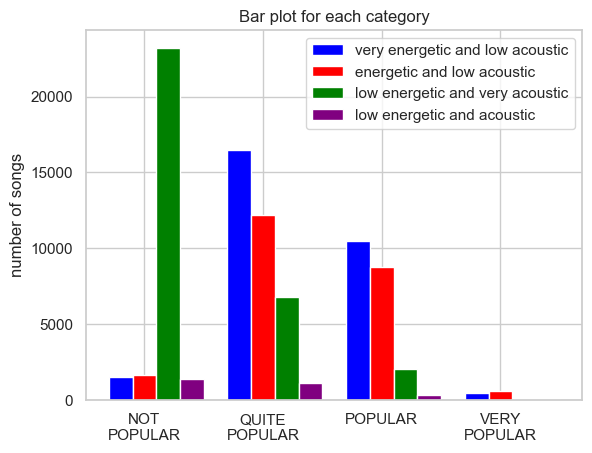

In [18]:
categories = [category.replace(" ", "\n") for category in quantize_popularity]

bar_width = 0.2
index = np.arange(len(categories))

plt.bar(index, molto_energica_poco_acustica, color='blue', label='very energetic and low acoustic', width=bar_width)
plt.bar(index + bar_width, energica_poco_acustica, color='red', label='energetic and low acoustic', width=bar_width)
plt.bar(index + 2*bar_width, poco_energica_molto_acustica, color='green', label='low energetic and very acoustic', width=bar_width)
plt.bar(index + 3*bar_width, poco_energica_acustica, color='purple', label='low energetic and acoustic', width=bar_width)

plt.ylabel('number of songs')
plt.title('Bar plot for each category')
plt.xticks(index + bar_width, categories)
plt.legend()
plt.show()

This plot confirms that:
- Among the less popular songs in the dataset, those with high values of `acousticness` stand out significantly.
- The moderately popular, popular, and very popular songs show a similar trend: as the `energy` decreases and the `acousticness` increases, the songs seem to become less popular.
- The gap between more energetic and less acoustic songs, and songs that are less energetic and more acoustic, increases as the popularity increases. In fact, the number of very popular songs that are less energetic and (very) acoustic is practically negligible.
- Even the quantity of very popular songs that are (very) energetic and less acoustic is relatively low compared to songs with the same characteristics but less popular. We can conclude that it is very difficult for a song to become very popular.
 
It is important to note that this analysis does not suggest that a song with high values of `energy` and low values of `acousticness` is definitely more popular than a song with high values of `acousticness` and low values of `energy`. _Correlation is not causation!_

Now let's display the energy values, separated by quantize_popularity, using box plots; let's do the same with the acousticness values.

<Axes: title={'center': 'acousticness'}, xlabel='quantize_popularity'>

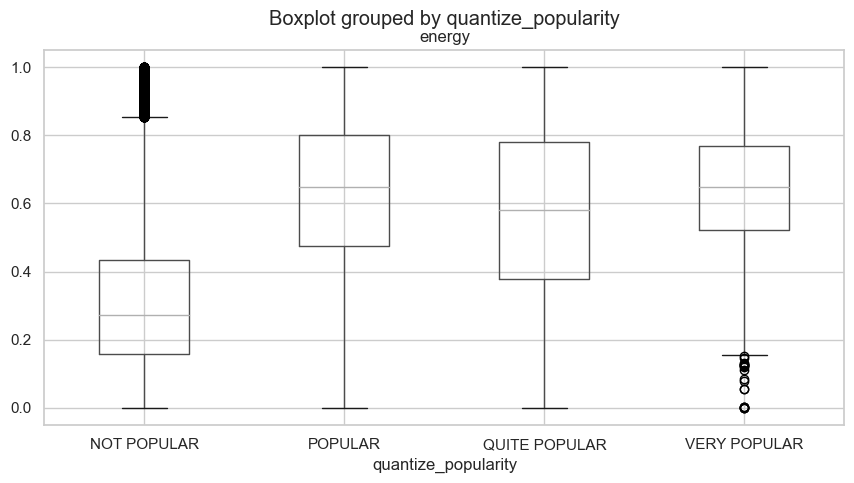

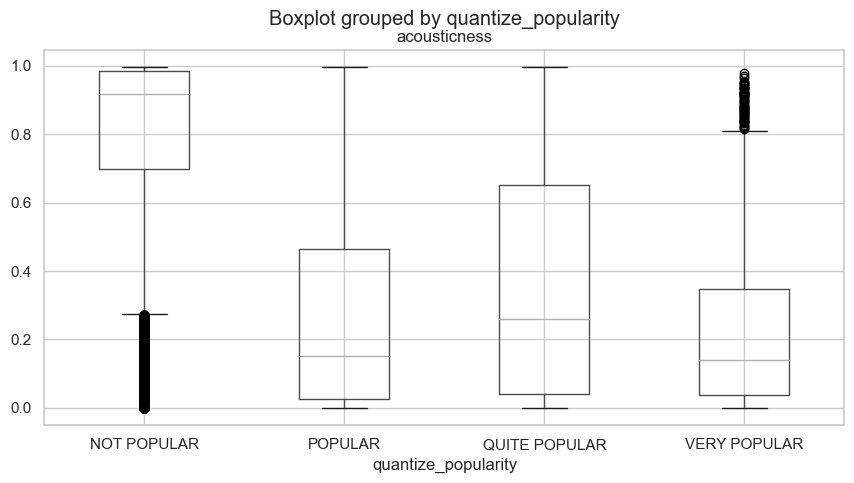

In [19]:
songs.boxplot(column='energy', by='quantize_popularity', figsize=(10,5))
songs.boxplot(column='acousticness', by='quantize_popularity', figsize=(10,5))

We observe that, consistently with what we have seen before, the lowest value of the median for `energy` belongs to the group of LOW POPULAR songs (i.e., less popular songs generally have lower values of energy), while the highest values of the median for `energy` belong to the VERY POPULAR and POPULAR groups.
The box plot for `acousticness` seems to be the "opposite" of the box plot for `energy`: the group of LOW POPULAR songs represents the group with the highest value of the median for `acousticness`, while the other groups show progressively lower values.

We also note that both for `energy` and `acousticness`, the box plots for POPULAR and VERY POPULAR songs are relatively similar.

At this point, we wonder if the difference in means between POPULAR and VERY POPULAR songs is statistically significant.

To answer this question, we can use a t-test.

We know that some assumptions must be met:
1. Sample size n > 30;
2. Population size at least ten times larger than the sample size N > 10*n.

First, let's print the number of elements for the two classes (POPULAR and VERY POPULAR).

In [20]:
songs[songs['quantize_popularity'] == 'POPULAR'].shape[0]

36664

In [21]:
songs[songs['quantize_popularity'] == 'VERY POPULAR'].shape[0]

1798

The hypotheses are verified, so we can apply a t-test on the `energy` values.

We choose a significance level of 0.05 (confidence interval of 0.95).

null hypothesis H0 = the means of energy for POPULAR and VERY POPULAR are not statistically different;

alternative hypothesis HA = the means are different.

In [22]:
t_value, p_value = ttest_ind(songs.loc[songs['quantize_popularity'] == 'VERY POPULAR', 'energy'], songs.loc[songs['quantize_popularity'] == 'POPULAR', 'energy'])
print("p value:", p_value)

alpha = 0.05
if p_value < alpha: 
    print("Reject H0: the means are statistically different")
else:
    print("We cannot reject H0: the means are not statistically different")

p value: 0.01203297354647808
Reject H0: the means are statistically different


Since p_value < significance level, we can reject the null hypothesis.

Now let's apply a t-test for `acousticness`.

We choose a significance level of 0.05 (confidence interval of 0.95).

null hypothesis H0 = the means of acousticness for POPULAR and VERY POPULAR are not statistically different;

alternative hypothesis HA = the means are different.

In [23]:
t_value, p_value = ttest_ind(songs.loc[songs['quantize_popularity'] == 'VERY POPULAR', 'acousticness'], songs.loc[songs['quantize_popularity'] == 'POPULAR', 'acousticness'])
print("p value:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Reject H0: the means are statistically different")
else:
    print("We cannot reject H0: the means are not statistically different")

p value: 1.994185868279432e-10
Reject H0: the means are statistically different


In this case too, we can reject the null hypothesis, and we have concluded that the averages of POPULAR and VERY POPULAR songs for energy and acousticness are statistically different.

### Clustering

Since the genre of the songs is not indicated in our dataset, it can be interesting to try to derive it through clustering of the songs based on the composition of certain musical features; we have chosen to base our clustering on the features `acousticness`, `danceability`, `energy`, `instrumentalness`, `speechiness`, and `valence`, which according to our research are the most characteristic factors of each music genre.

After normalizing our columns to make them "weigh" equally, we try to create 10 clusters using the k-means method:

/Users/sararosselli/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


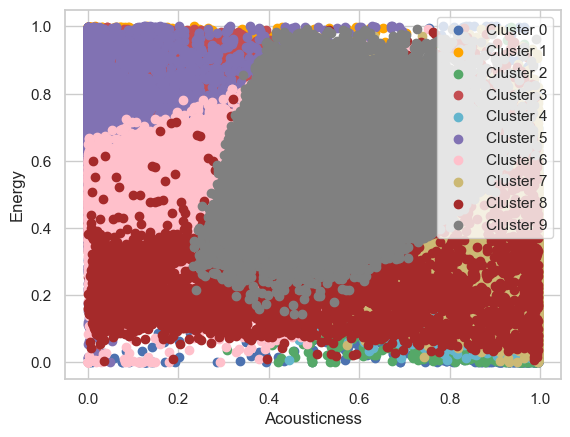

In [24]:
features_to_normalize = ["acousticness", "danceability", "energy", "instrumentalness", "speechiness", "valence"]
songs_normalized = songs[features_to_normalize].copy()

scaler = MinMaxScaler()

songs_normalized[features_to_normalize] = scaler.fit_transform(songs_normalized)

kmeans = KMeans(n_clusters=10, random_state=1)
clusters = kmeans.fit_predict(songs_normalized)
songs["cluster"] = clusters

# Traccia il grafico
color = ['b','orange','g','r', 'c', 'm', 'pink', 'y', 'brown', 'gray']
for i in range(0, 10):
    plt.scatter(songs.loc[songs['cluster'] == i, 'acousticness'], 
                songs.loc[songs['cluster'] == i, 'energy'], 
                color=color[i], label='Cluster ' + str(i))

plt.xlabel('Acousticness')
plt.ylabel('Energy')
plt.legend()
plt.show()

The clustering plot is very confusing because we are visualizing a plot based on the composition of six dimensions in just two dimensions.

Now let's display a box plot for each musical feature of the clustering, in order to analyze the differences between our 10 clusters and identify a music genre for each of them.

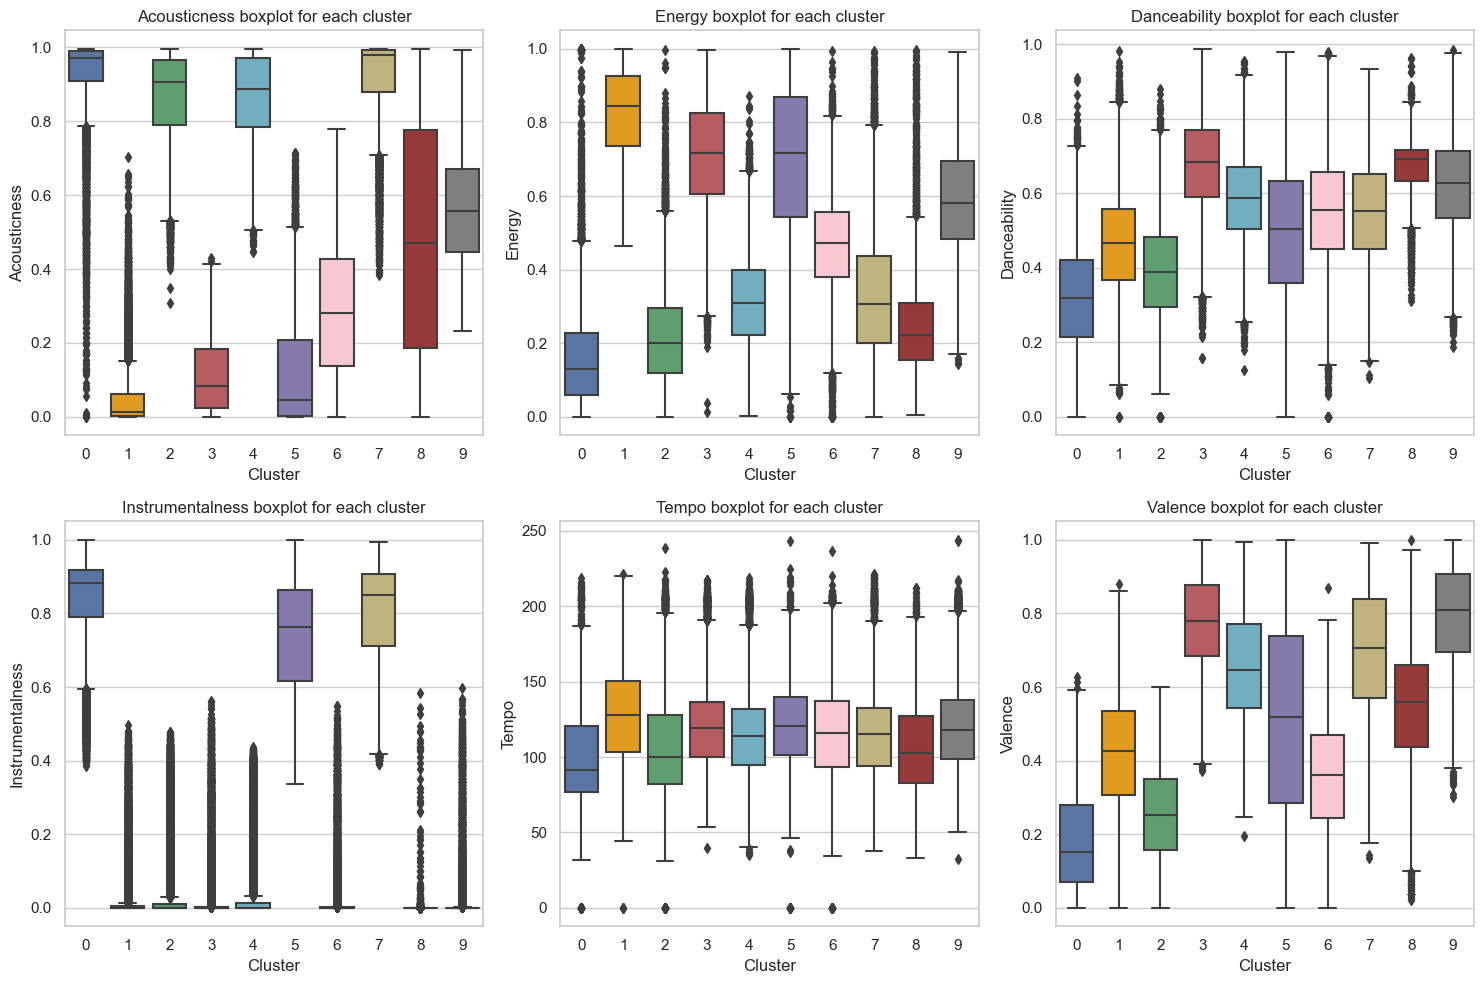

In [25]:
num_rows = 2
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

features = ['acousticness', 'energy', 'danceability', 'instrumentalness', 'tempo', 'valence']

for i, feature in enumerate(features):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(data=songs, x='cluster', y=feature, palette=color, ax=axes[row, col])
    axes[row, col].set_xlabel('Cluster')
    axes[row, col].set_ylabel(feature.capitalize())
    axes[row, col].set_title(f'{feature.capitalize()} boxplot for each cluster')

plt.tight_layout()
plt.show()

Now let's display the 5 most popular songs for each cluster and observe the values of their features, to better identify common characteristics.

In [26]:
grouped = songs.groupby('cluster')

# dictionary to store the top 5 songs by cluster
top_songs_by_cluster = {}

# find the top 5 songs by popularity for each cluster
for cluster, group in grouped:
    top_songs = group.nlargest(5, 'popularity')
    top_songs_by_cluster[cluster] = top_songs

# print the top 5 songs for each cluster
for cluster, top_songs in top_songs_by_cluster.items():
    print(f"Cluster {cluster}:")
    print(top_songs[['name', 'artists', 'popularity', 'acousticness', 'energy', 'instrumentalness', 'tempo', 'valence', 'danceability', 'speechiness']])
    print()

Cluster 0:
                                             name  \
165442                        everything i wanted   
25540   Clean White Noise - Loopable with no fade   
159092                       White Noise - 145 hz   
124959                           Soft Brown Noise   
46157                                 Forest Rain   

                                                  artists  popularity  \
165442                                      Billie Eilish          90   
25540   Erik Eriksson, White Noise Baby Sleep, White N...          86   
159092                                           Granular          80   
124959                              High Altitude Samples          78   
46157                                     Rain Recordings          77   

        acousticness   energy  instrumentalness    tempo  valence  \
165442         0.902  0.22500             0.657  120.006  0.24300   
25540          0.791  0.00342             1.000    0.000  0.00000   
159092         0.944  0.

According to our observations, the musical genres of each cluster are:

- Cluster 0: **Ambient music, which can be, for example, classical or natural**: it's relaxing and regular music, stimulating concentration, characterized by high acousticness, high instrumentalness, low energy, and low valence.
- Cluster 1: **Energetic pop and rock music**, characterized by high energy, low acousticness, and low instrumentalness.
- Cluster 2: **Acoustic music like jazz, and melancholic pop**, characterized by high acousticness, low instrumentalness, low energy, and low valence.
- Cluster 3: **Rap and commercial pop**, characterized by high energy, high valence, high danceability, low acousticness, and low instrumentalness.
- Cluster 4: **Emotional, introspective tracks**, characterized by high acousticness, high valence, and low instrumentalness.
- Cluster 5: **Regular music with a lot of bass like techno**, characterized by high energy, high instrumentalness, high tempo, and low acousticness.
- Cluster 6: **Hip-hop**, characterized by low acousticness, low instrumentalness, and average values for every other feature.
- Cluster 7: **Chill-out music, light and instrumental music**, characterized by high acousticness, high instrumentalness, and high valence.
- Cluster 8: **Hard and masculine rap**, characterized by high speechiness, high danceability, and fairly low values for every other feature.
- Cluster 9: **Dance pop, lively and carefree music**, characterized by high valence, high danceability, and high tempo.

Now, thanks to our silhouette function, let's try to see what would be the optimal number of clusters (i.e., the number of music genres) to assign a genre to the songs in the dataset:

In [27]:
def silhouette(x):
    silhouette_avg = []
    for i in range(2, 15):
        # let's consider only 10.000 samples to speed up the computation
        sampled_data = shuffle(x, random_state=0)[:10000] 
        kmeans = KMeans(n_clusters=i, max_iter=20, random_state=0)
        cluster_labels = kmeans.fit_predict(sampled_data)
        silhouette_avg.append(silhouette_score(sampled_data, cluster_labels))
   
    plt.plot(range(2, 15), silhouette_avg,'-o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette coefficient')
    plt.show()

/Users/sararosselli/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/sararosselli/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/sararosselli/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/sararosselli/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of

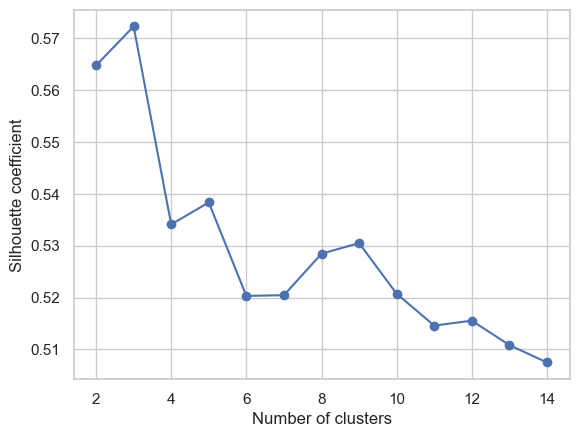

In [28]:
silhouette(songs[["acousticness", "danceability", "energy", "instrumentalness", "tempo", "valence"]])

From this plot, it seems that the ideal number of clusters is 3, which is a much lower number compared to the 10 we used.

Let's try to re-run the previous analysis on the 3 clusters to identify the 3 macro-genres that can be obtained:

/Users/sararosselli/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


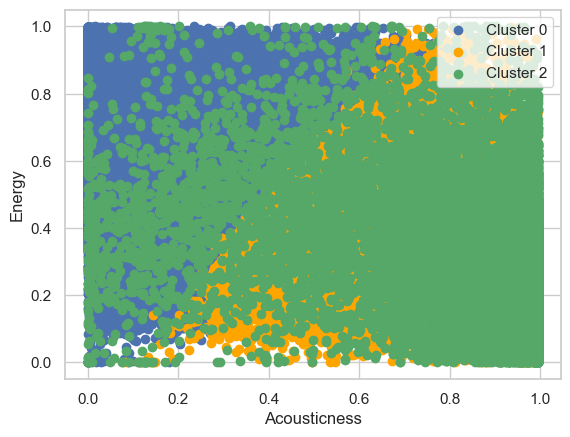

In [29]:
scaler = MinMaxScaler()

songs_normalized[features_to_normalize] = scaler.fit_transform(songs_normalized)

kmeans = KMeans(n_clusters=3, random_state=1)
clusters = kmeans.fit_predict(songs_normalized)
songs["cluster_2"] = clusters

color = ['b','orange','g']
for i in range(0, 3):
    plt.scatter(songs.loc[songs['cluster_2'] == i, 'acousticness'], 
                songs.loc[songs['cluster_2'] == i, 'energy'], 
                color=color[i], label='Cluster ' + str(i))

plt.xlabel('Acousticness')
plt.ylabel('Energy')
plt.legend()
plt.show()

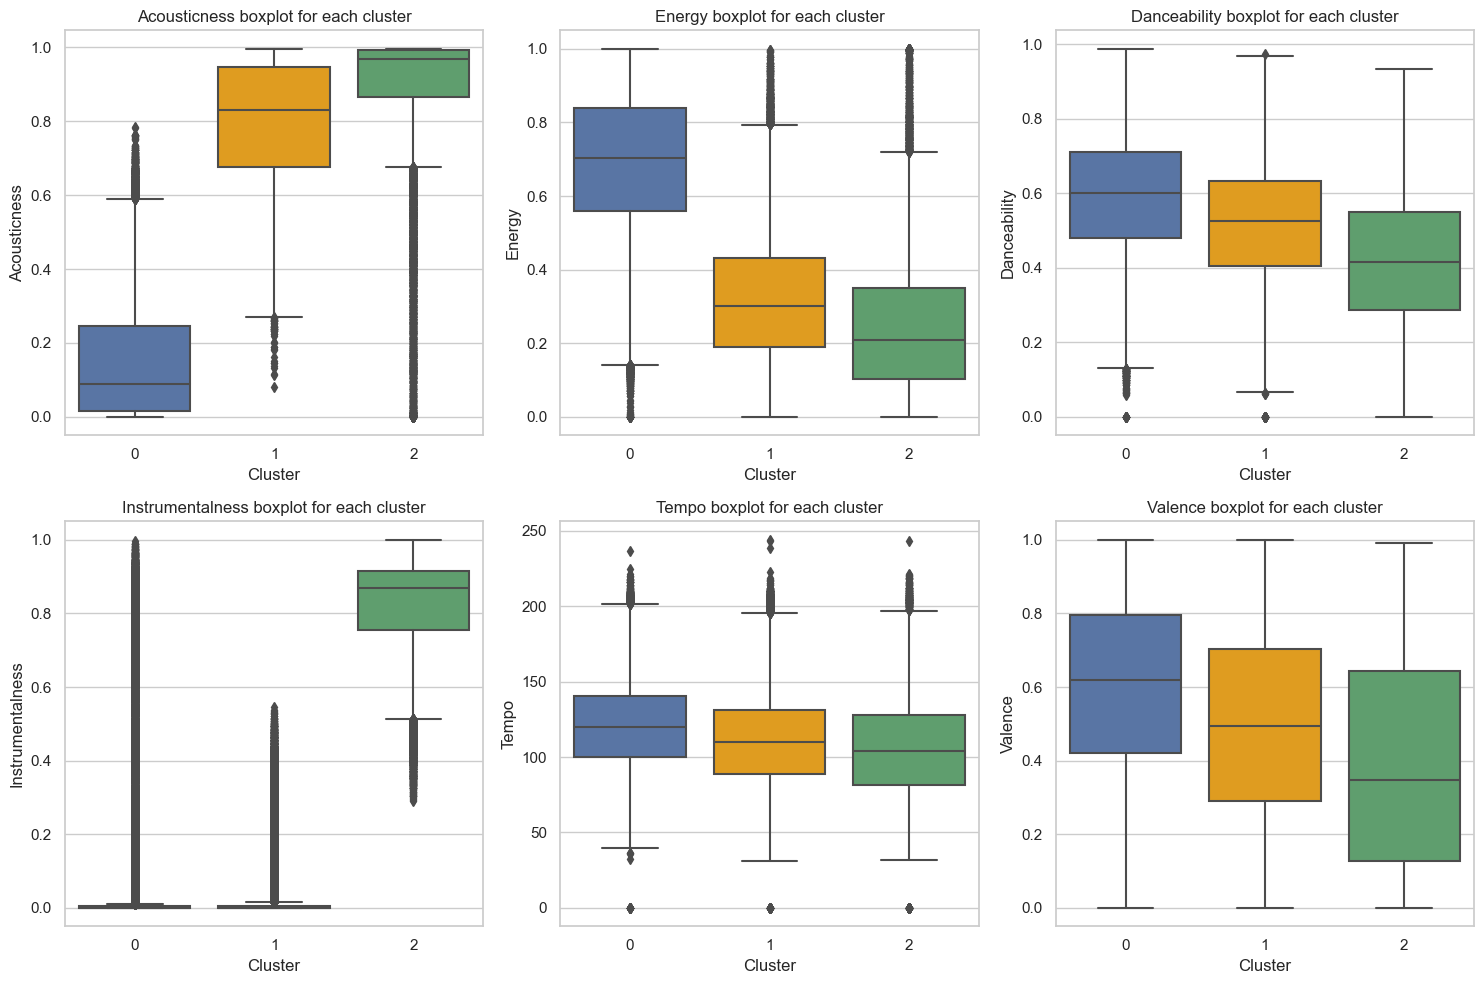

In [30]:
num_rows = 2
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

features = ['acousticness', 'energy', 'danceability', 'instrumentalness', 'tempo', 'valence']

for i, feature in enumerate(features):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(data=songs, x='cluster_2', y=feature, palette=color, ax=axes[row, col])
    axes[row, col].set_xlabel('Cluster')
    axes[row, col].set_ylabel(feature.capitalize())
    axes[row, col].set_title(f'{feature.capitalize()} boxplot for each cluster')

plt.tight_layout()
plt.show()

In [31]:
grouped = songs.groupby('cluster_2')

top_songs_by_cluster = {}

for cluster, group in grouped:
    top_songs = group.nlargest(5, 'popularity')
    top_songs_by_cluster[cluster] = top_songs

for cluster, top_songs in top_songs_by_cluster.items():
    print(f"Cluster {cluster}:")
    print(top_songs[['name', 'artists', 'popularity', 'acousticness', 'energy', 'instrumentalness', 'tempo', 'valence', 'danceability', 'speechiness']])
    print()

Cluster 0:
                                name                             artists  \
16539                Blinding Lights                          The Weeknd   
111992  ROCKSTAR (feat. Roddy Ricch)                 DaBaby, Roddy Ricch   
134148                    THE SCOTTS  THE SCOTTS, Travis Scott, Kid Cudi   
131973                    Supalonely                BENEE, Gus Dapperton   
137845                       The Box                         Roddy Ricch   

        popularity  acousticness  energy  instrumentalness    tempo  valence  \
16539          100       0.00146   0.730          0.000095  171.005    0.334   
111992          99       0.24700   0.690          0.000000   89.977    0.497   
134148          96       0.23300   0.537          0.000000  129.979    0.280   
131973          95       0.30500   0.631          0.000030  128.977    0.817   
137845          95       0.10400   0.586          0.000000  116.971    0.642   

        danceability  speechiness  
16539          

According to our observations, the musical genres of each cluster are:

- Cluster 0: **dance and pop music**, characterized by high danceability, high energy, high valence, low acousticness, and low instrumentalness.
- Cluster 1: **acoustic music**, characterized by high acousticness, low energy, and low instrumentalness.
- Cluster 2: **ambient music**, characterized by high acousticness, high instrumentalness, and low energy.

This clustering seems too approximative, probably because it does not take into account the vast number of musical genres that we have today and that differ for small details; therefore, we prefer to keep our clustering to 10 genres.

Let's see again the correlation heatmap of the dataset's columns:

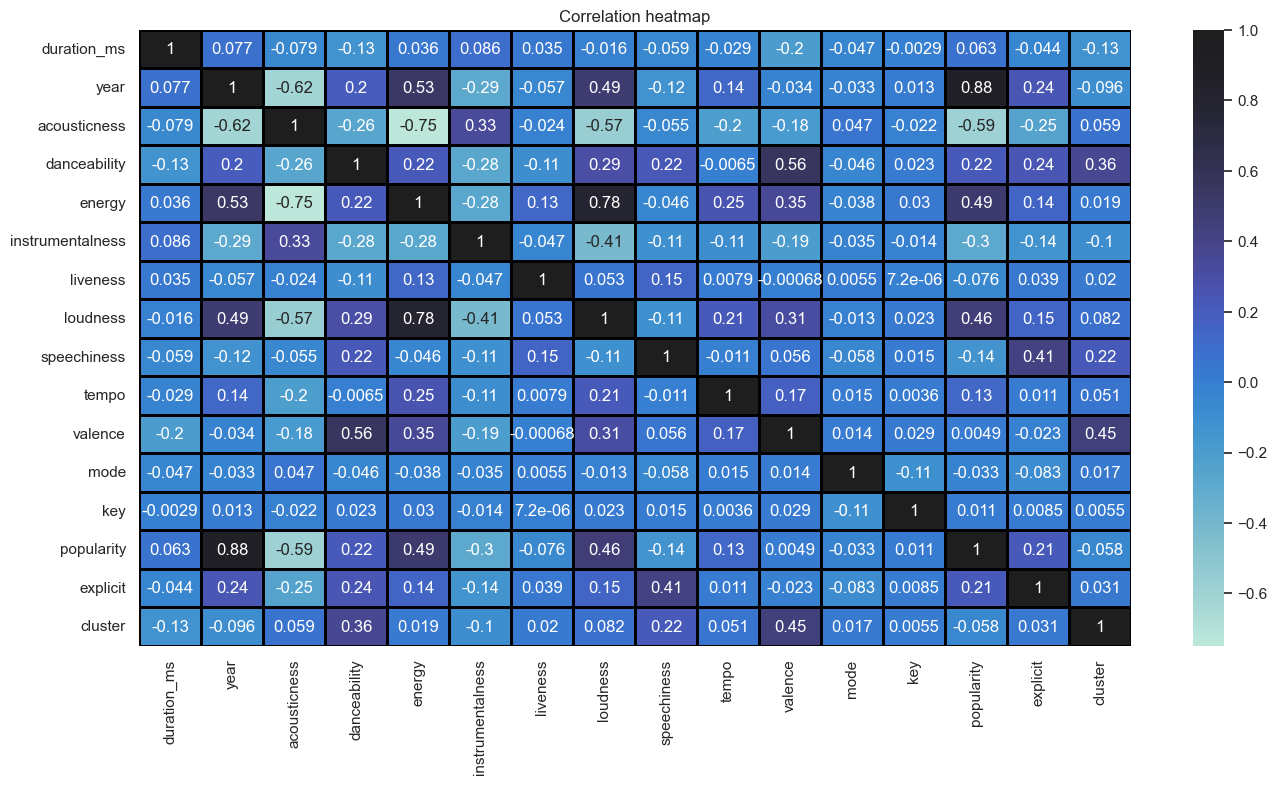

In [32]:
songs.drop(["cluster_2"], axis=1, inplace=True)
songs_2 = songs.select_dtypes(include=[np.number])
plt.figure(figsize=(16,8))
plt.title('Correlation heatmap')
ax=sns.heatmap(songs_2.corr(),
               linewidth=2,
               annot=True,
               linecolor='black',
               center=1)

From the heatmap, we can see that the music genre (column `cluster` in our dataset) is not correlated with popularity at all, so it is not worth using it for our analysis

### Linear regression to predict popularity

To achieve our goal of predicting the popularity of a song based on certain musical features, we will use the features `energy`, `loudness`, `acousticness`, and `instrumentalness`.

We will not use the `year` column even though it seems to be the most correlated with `popularity`, because it is not an attribute that artists can directly manipulate.

Let's create the function PlotRegression(x) that will:

   1. Take as input the feature we want to study;
   2. Split the dataset into a training set and a validation set;
   3. Instantiate an object of the LinearRegression class;
   4. Train the model using the fit function called on the instantiated object;
   5. Use the learned model to make predictions on the validation set by calling the predict function on the object returned by fit to obtain the corresponding values lying on the line;
   6. Print the errors, including the null model's ones, to verify its efficiency (we will calculate: mean absolute error (MAE); mean squared error (MSE); root mean squared error (RMSE))

Remember that the null model (where I predict the mean of the variable by "guessing" the expected result over and over again) should have a higher error than my model in order for my model to be considered effective.

In [33]:
def RegressionPlot(x):
    features = [x]
    X = songs[features]
    y = songs['popularity']

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    regr = LinearRegression()
    lin_reg = regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    
    plt.figure(figsize=(12,6))
    plt.scatter(X, y, color="r")
    plt.plot(np.array(X), np.array(X*lin_reg.coef_ + lin_reg.intercept_), color = 'b')

    print("Coefficient: ", regr.coef_)
    print ('MAE: %.3f' % metrics.mean_absolute_error(y_test, y_pred))
    print ('MSE: %.3f' % metrics.mean_squared_error(y_test, y_pred))
    print ('RMSE: %.3f \n' % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    
    mean_popularity = songs['popularity'].mean()
    null_model_y = [mean_popularity] * X_test.shape[0]
    
    print('null model: ')
    print ('MAE:%.3f' % metrics.mean_absolute_error(y_test, null_model_y))
    print ('MSE:%.3f' % metrics.mean_squared_error(y_test, null_model_y))
    print ('RMSE:%.3f \n'% np.sqrt(metrics.mean_squared_error(y_test, null_model_y)))

    df_output = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    print(df_output)

    plt.show()

Let's run the function with `energy`:

Coefficient:  [0.39883476]
MAE: 15.501
MSE: 349.161
RMSE: 18.686 

null model: 
MAE:18.206
MSE:463.936
RMSE:21.539 

        Actual  Predicted
37561       47  49.089830
123048      32  38.760010
158447      21  36.925370
83824       61  35.130614
39096        0  32.259004
...        ...        ...
63373       58  48.371928
112799      42  30.025529
89351        0  28.390306
68773       46  34.492478
155541      31  27.632520

[42325 rows x 2 columns]


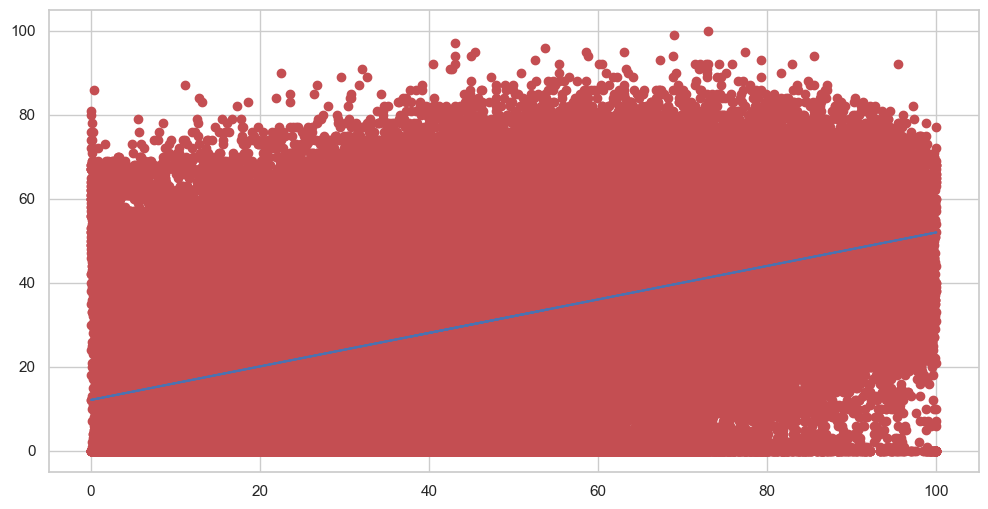

In [34]:
# Normalize 'energy' in the range 0-100
energy_normalized = (songs['energy'] - songs['energy'].min()) / (songs['energy'].max() - songs['energy'].min()) * 100
songs['energy_normalized'] = energy_normalized
RegressionPlot('energy_normalized')

Let's run the function with `loudness`:

Coefficient:  [1.12966437]
MAE: 15.464
MSE: 363.723
RMSE: 19.072 

null model: 
MAE:18.206
MSE:463.936
RMSE:21.539 

        Actual  Predicted
37561       47  41.293889
123048      32  28.156487
158447      21  33.752178
83824       61  42.712714
39096        0  42.098833
...        ...        ...
63373       58  39.638003
112799      42  30.693389
89351        0  34.866717
68773       46  29.009198
155541      31  28.344013

[42325 rows x 2 columns]


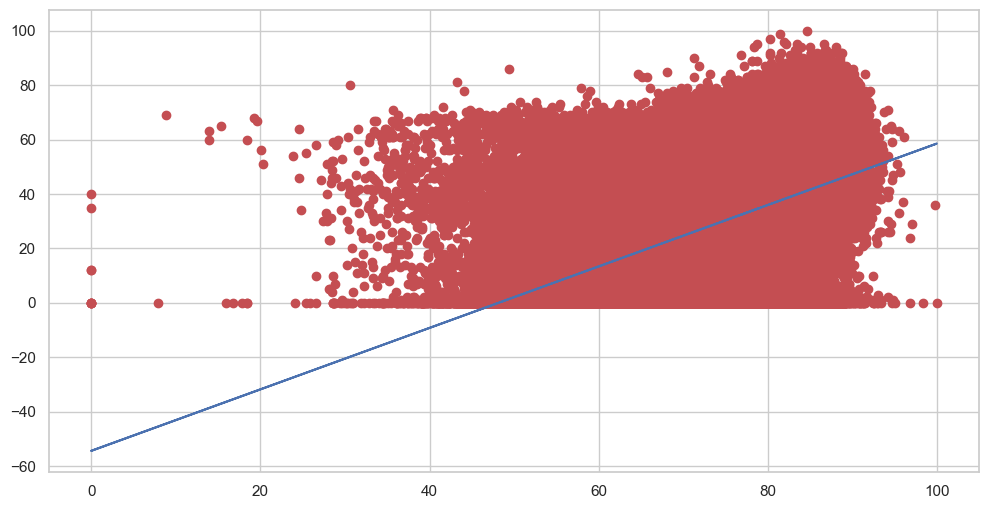

In [35]:
loudness_normalized = (songs['loudness'] - songs['loudness'].min()) / (songs['loudness'].max() - songs['loudness'].min()) * 100
songs['loudness_normalized'] = loudness_normalized
RegressionPlot('loudness_normalized')

Let's run the function with `acousticness`:

Coefficient:  [-0.33722869]
MAE: 14.198
MSE: 302.150
RMSE: 17.382 

null model: 
MAE:18.206
MSE:463.936
RMSE:21.539 

        Actual  Predicted
37561       47  45.170044
123048      32  47.441936
158447      21  28.593019
83824       61  44.100121
39096        0  15.320564
...        ...        ...
63373       58  48.286802
112799      42  27.678845
89351        0  15.083556
68773       46  47.160912
155541      31  42.339489

[42325 rows x 2 columns]


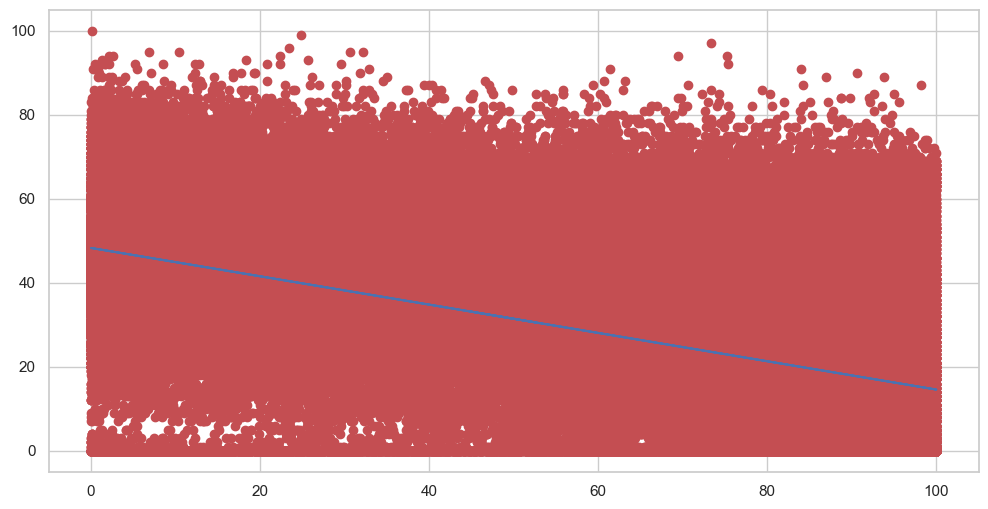

In [36]:
acousticness_normalized = (songs['acousticness'] - songs['acousticness'].min()) / (songs['acousticness'].max() - songs['acousticness'].min()) * 100
songs['acousticness_normalized'] = acousticness_normalized
RegressionPlot('acousticness_normalized')

Let's run the function with `instrumentalness`:

Coefficient:  [-0.20661194]
MAE: 17.213
MSE: 423.364
RMSE: 20.576 

null model: 
MAE:18.206
MSE:463.936
RMSE:21.539 

        Actual  Predicted
37561       47  16.715699
123048      32  34.868211
158447      21  34.979455
83824       61  34.980194
39096        0  19.091736
...        ...        ...
63373       58  34.979517
112799      42  34.980194
89351        0  34.977260
68773       46  34.979353
155541      31  34.302507

[42325 rows x 2 columns]


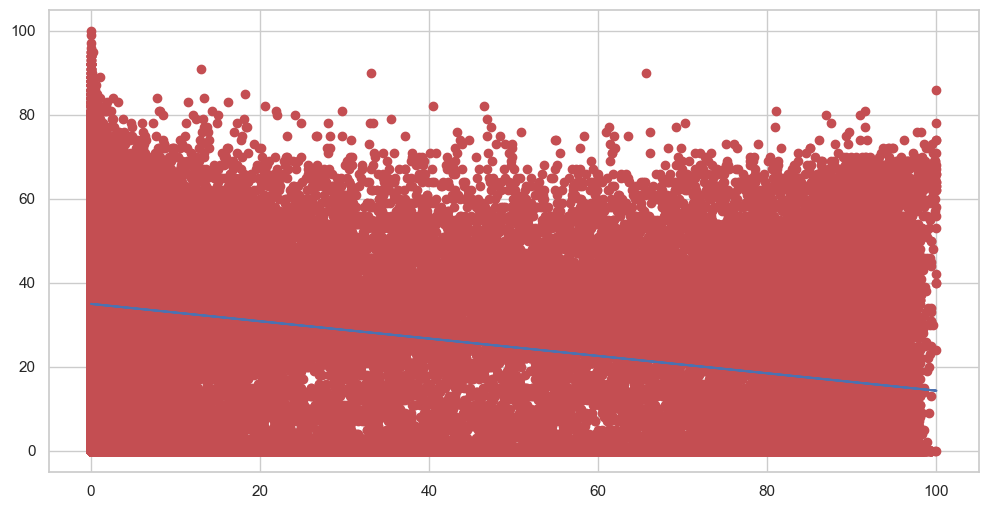

In [37]:
instrumentalness_normalized = (songs['instrumentalness'] - songs['instrumentalness'].min()) / (songs['instrumentalness'].max() - songs['instrumentalness'].min()) * 100
songs['instrumentalness_normalized'] = instrumentalness_normalized
RegressionPlot('instrumentalness_normalized')

From these results, it seems that the Linear Regression model on individual features is not a great candidate as a prediction method: the error values on our model are very close to the error values of the null model, and the predicted values are generally quite far from the true values of the features.

Let's try using all the features together for popularity prediction:

In [38]:
y = songs['popularity']
features = ['acousticness', 'energy', 'instrumentalness', 'loudness']
songs_cut = songs[features]

scaler = MinMaxScaler()
X = scaler.fit_transform(songs_cut)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
regr = LinearRegression()
lin_reg = regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

print('MAE: %.3f' % metrics.mean_absolute_error(y_test, y_pred))
print('MSE: %.3f' % metrics.mean_squared_error(y_test, y_pred))
print('RMSE: %.3f \n' % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

mean_pop = songs['popularity'].mean()
null_model_y = [mean_pop] * X_test.shape[0]

print('null model:')
print('MAE: %.3f' % metrics.mean_absolute_error(y_test, null_model_y))
print('MSE: %.3f' % metrics.mean_squared_error(y_test, null_model_y))
print('RMSE: %.3f \n' % np.sqrt(metrics.mean_squared_error(y_test, null_model_y)))

accuracy = regr.score(X_test, y_test)
print('Accuracy of our model:', accuracy)

MAE: 13.779
MSE: 288.605
RMSE: 16.988 

null model:
MAE: 18.206
MSE: 463.936
RMSE: 21.539 

Accuracy of our model: 0.3779214810932734


With this new set of selected features, the performance of the Linear Regression model does not seem to have improved very much.

### Logistic Regression to Predict Popularity

We can try to transform the regression problem into a classification problem by using the Logistic Regression method.

We want to predict the probability that a data belongs to the "popular" class. To do this, we first convert the `quantize_popularity` variable to have only two possible values: "not popular" if its `popularity` value is between 0 and 49, and "popular" ( = 1 in our model) if it is between 50 and 100.

In [39]:
quantize_popularity = lambda x: 'not popular' if x <= 49 else 'popular'
songs['quantize_popularity'] = songs['popularity'].apply(quantize_popularity)

In [40]:
features_to_normalize = ['energy', 'acousticness', 'instrumentalness', 'loudness']
songs_normalized = songs[features_to_normalize].copy()

scaler = MinMaxScaler()
songs_normalized[features_to_normalize] = scaler.fit_transform(songs_normalized)

songs_normalized['quantize_popularity'] = songs['quantize_popularity']
X = songs_normalized.drop(columns=['quantize_popularity'])
y = (songs_normalized['quantize_popularity'] == 'popular').astype(int) # 1 if popular, else 0

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

accuracy = log_reg.score(X_test, y_test)
print('Accuracy of our model:', str(accuracy) + '\n')

Accuracy of our model: 0.7908092144122859



We obtain an accuracy in the results of about 80%, a good value and definitely improved compared to the 40% of the Linear Regression model.

We can visualize a ROC curve, which is a graphical representation of the performance of our binary classification model as the decision threshold varies, to see the trade-off between the false positive rate and the true positive rate at different thresholds.

False Positive Rate (FPR): it's the proportion of negative instances that are incorrectly classified as positive.

True Positive Rate (TPR): it's the proportion of positive instances that are correctly classified as positive.

The ROC curve shows the relationship between FPR and TPR as the decision threshold of the model varies. Ideally, we would want the ROC curve to approach the point (0,1) in the top left corner of the graph, which would indicate a model with high TPR and low FPR regardless of the decision threshold.

The area under the ROC curve (AUC) is an important measure of model performance: a higher AUC indicates a greater discriminative ability of the model, i.e., the ability to distinguish between positive and negative classes (an AUC value of 0.5 indicates a model that randomly classifies instances).

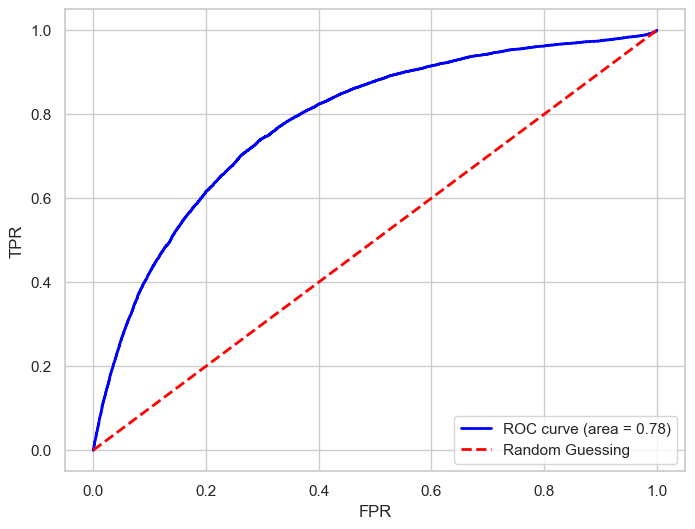

In [41]:
y_probs = log_reg.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

roc_auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random Guessing')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

##### References

- Kaggle, [SpotifyData.ipynb](https://www.kaggle.com/datasets/fcpercival/160k-spotify-songs-sorted?resource=download&select=Spotify+Data.ipynb)
- Bliss, [The fundamental music genre list](https://www.blisshq.com/music-library-management-blog/2011/01/25/fundamental-music-genre-list/)